In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH)

In [3]:
corr = np.corrcoef(tX.T)

In [4]:
import seaborn as sns

In [9]:
headers.shape

(30,)

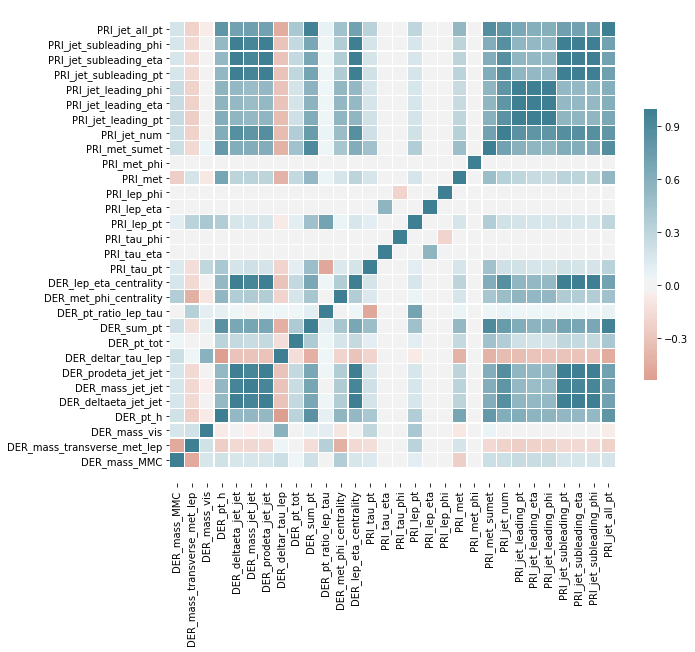

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=sns.diverging_palette(20, 220, n=200), center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5}, ax=ax)
ax.set_xticks(np.arange(len(headers))+0.5)
ax.set_yticks(np.arange(len(headers))+0.5)

ax.set_xticklabels(headers, rotation=90);
ax.set_yticklabels(headers, rotation=0);
ax.set_ylim(-1,31);


## Do your thing crazy machine learning thing here :) ...

#### Studying the distribution of variables to detect possible categorical or faulty values

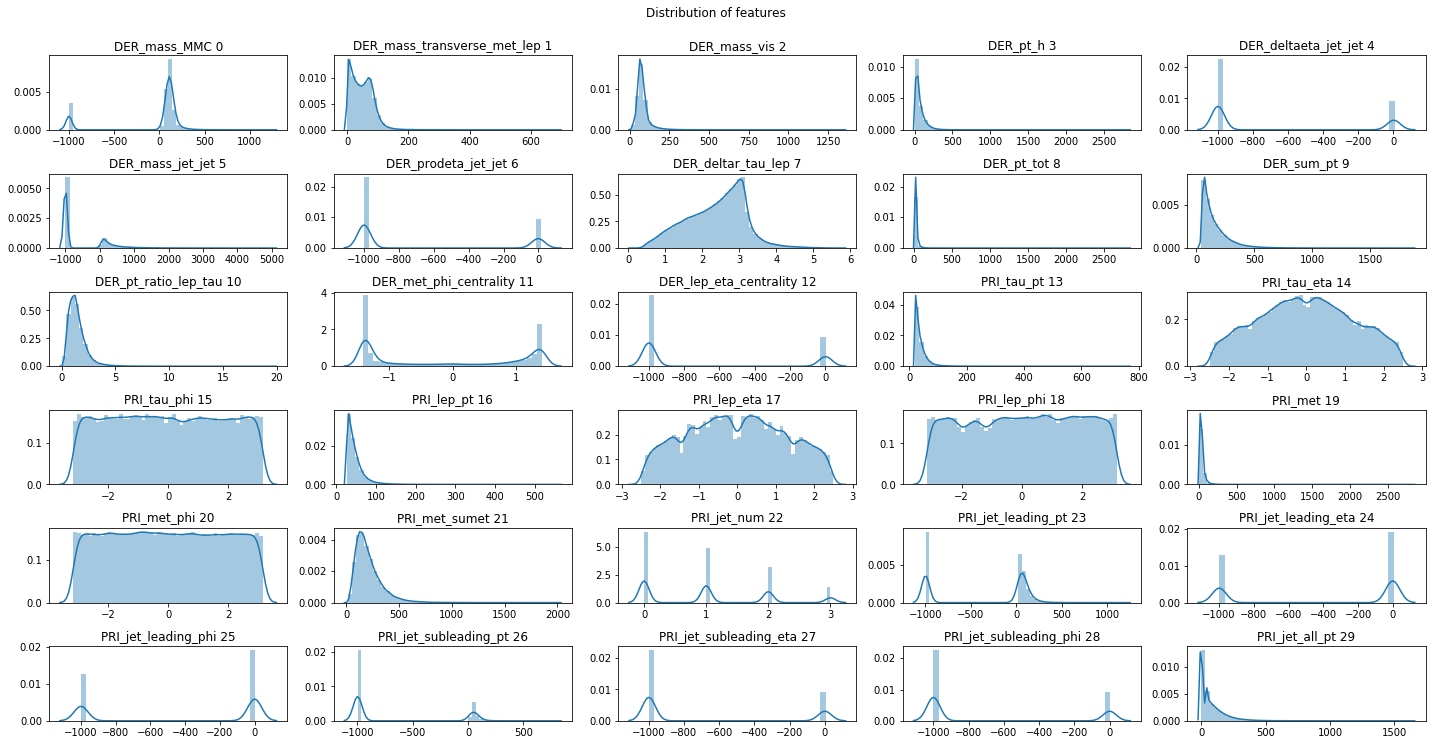

In [232]:
from plots import plot_feature_distribution
plot_feature_distribution(tX, headers, np.arange(len(headers)), "Distribution of features", 5, 6)

As we can see from these plots, different features have different distributions. We can also notice that there seems to be one categorical feature, namely `PRI_jet_num`. This feature is the number of jets used during the experiment. If we look at the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf), we can see that some feature are actually affected by the number of jets used.

Features affected by undefined values:
- `DER_mass_MMC` ID=0: undefined if topology of event too far from expected
- `DER_deltaeta_jet_jet` ID=4 : undefined if `PRI_jet_num` <= 1
- `DER_mass_jet_jet` ID=5: undefined if `PRI_jet_num` <= 1
- `DER_prodeta_jet_jet` ID=6: undefined if `PRI_jet_num` <= 1
- `DER_lep_eta_centrality` ID=12: undefined if `PRI_jet_num` <= 1
- `PRI_jet_leading_pt` ID=23: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_eta` ID=24: undefined if `PRI_jet_num` == 0
- `PRI_jet_leading_phi` ID=25: undefined if `PRI_jet_num` == 0
- `PRI_jet_subleading_pt` ID=26: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_eta` ID=27: undefined if `PRI_jet_num` <= 1
- `PRI_jet_subleading_phi` ID=28: undefined if `PRI_jet_num` <= 1

Hence, it might be a good idea to have estimators for each number of jets (0, 1, and more than 1).
Also, we can see that features `PRI_tau_phi`, `PRI_lep_phi` and `PRI_met_phi` have an almost uniform distribution.

For now, we will split the dataset into 6 categories:
- `tX_0, y_0` : Features and labels for experiments with 0 jets, that have a defined `DER_mass_MMC`
- `tX_0_nm,, y_0_nm`:  Features and labels for experiments with 0 jets, that have an undefined `DER_mass_MMC`
- `tX_1, y_1` : Features and labels for experiments with 1 jet, that have a defined `DER_mass_MMC`
- `tX_1_nm, y_1_nm`: Features and labels for experiments with 1 jet, that have an undefined `DER_mass_MMC`
- `tX_2, y_2` : Features and labels for experiments with more than 1 jets
- `tX_2_nm, y_2_nm`: Features and labels for experiments with more than 1 jet, that have an undefined `DER_mass_MMC`



In [24]:
from data_processing import split_dataset

jet_column = 22
mass_col = 0
tX_0, y_0, tX_0_nm, y_0_nm, tX_1, y_1, tX_1_nm, y_1_nm, tX_2, y_2, tX_2_nm, y_2_nm = split_dataset(tX, y, jet_col=jet_column, mass_col=0) # Split into each category

Now that we have split the dataset, we need to select the columns that are meaningful for each category, and add some features using polynomial expansion, exponential, logarithm and so on. For that, we have created a function `enhance_features`. This function adds all the expansions and performs PCA to project the feature matrix on a new basis

In [253]:
from data_processing import prepare_for_training
from implementations import reg_logistic_regression, logistic_regression, reg_logistic_regression_l1, reg_logistic_regression_sgd, ridge_regression
from cross_validation import cross_validate_degrees, cross_validate_reg

def select_features(x, y, train_ratio, max_iters, gamma, lambda_):
    x_train, y_train, x_test, y_test = prepare_for_training(x, y, None, train_ratio)
    initial_w = np.zeros((x_train.shape[1], 1))
    weights, loss = reg_logistic_regression_l1(y_train, x_train, lambda_, initial_w, max_iters, gamma, _print=False)

    score = compute_accuracy(y_test, x_test, weights)
    print(f"Regularized Logistic regression got score of {score}, loss of {loss}")
    
    #Select features that cumulate 95% of the weights
    perc = (np.abs(weights) / np.sum(np.abs(weights)))
    with_index = [(i, x) for i, x in enumerate(perc.ravel())]
    sorted_perc = np.array(sorted(with_index, key=lambda x: x[1], reverse=True))
    cum = np.cumsum([x[1] for x in sorted_perc])
    selected_cols = sorted_perc[np.where(cum <= 0.95)[0]][:, 0].astype(int)
    print(f"Feature selection using L1 regularization selected {len(selected_cols)} features")
    return selected_cols

def train_model(x, y, train_ratio, cols, max_iters, gamma, lambda_):
    x_train, y_train, x_test, y_test = prepare_for_training(x, y, cols, train_ratio, logistic=False)
    initial_w = np.zeros((x_train.shape[1], 1))
    weights, loss = ridge_regression(y_train, x_train, lambda_)

    score = compute_accuracy(y_test, x_test, weights)
    print(f"Regularized Logistic regression got score of {score}, loss of {loss}")
    return weights




#### A few global variable declarations

In [169]:
from pca import perform_pca
from feature_expansion import expand_features
pca_threshold = 0.99

### Category 0

The first thing to do, since we have 30 features, is to try and grasp which of those explain the most of variance within features. For that, we perform a Principle Component Analysis, and retain those components that explain 99% of the cumulative variance. That can be explained by the plot below

The 18 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet']

We can see that 13 features explain 99.0% of the cumulative variance


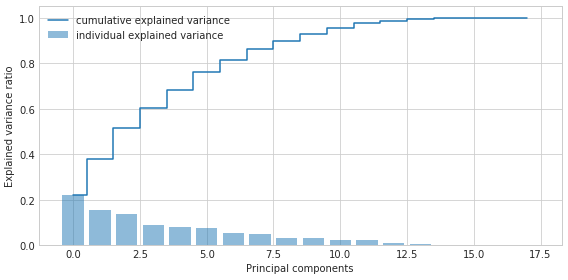

In [251]:
tX_0, matrix_0 = perform_pca(tX_0, headers, pca_threshold, True, None, print_=True)

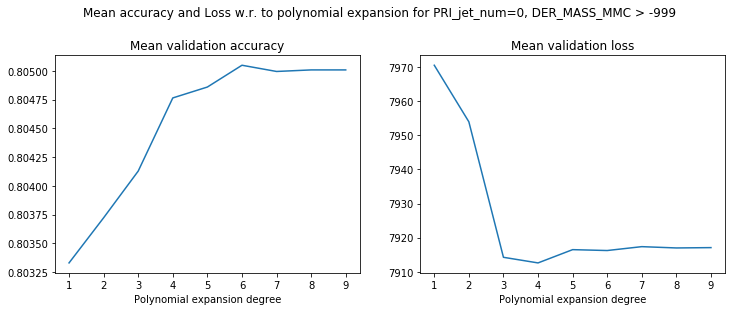

In [7]:
cross_validate_degrees(tX_0, y_0, 1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC > -999")

As we can see, a degree of 4 gives the lowest loss, and a relatively higher accuracy, so we will choose this one

In [255]:
degree_0 = 4
train_ratio = 0.9
tX_0_exp = expand_features(tX_0, degree_0, print_=True)

Performing polynomial expansion up to degree 4
Matrix has now 117 features


In [103]:
selected_cols_0 = select_features(tX_0_exp, y_0, train_ratio, 1000, 1e-5, 1)

Regularized Logistic regression got score of 0.8106789537877761, loss of 28383.162853147478
Feature selection using L1 regularization selected 67 features


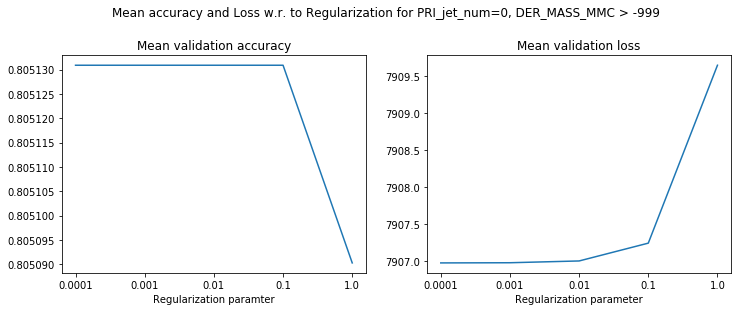

In [27]:
cross_validate_reg(tX_0_exp, y_0, selected_cols_0, 1e-5, np.logspace(-4, 0, 5), 4, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=0, DER_MASS_MMC > -999")

In [256]:
w_0 = train_model(tX_0_exp, y_0, train_ratio, selected_cols, 1400, 1e-5, 1e-2)

Regularized Logistic regression got score of 0.8066133622442065, loss of 0.2993752106176629


### Category 0, no mass defined

The 17 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet']

We can see that 12 features explain 99.0% of the cumulative variance


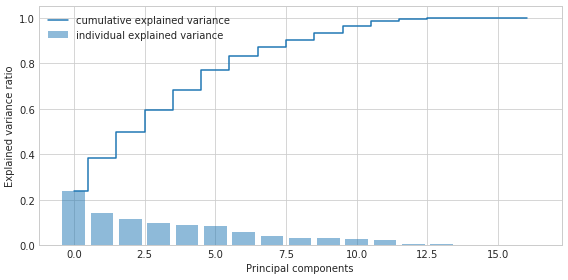

In [257]:
tX_0_nm, matrix_0_nm = perform_pca(tX_0_nm, headers, pca_threshold, True, None, print_=True)

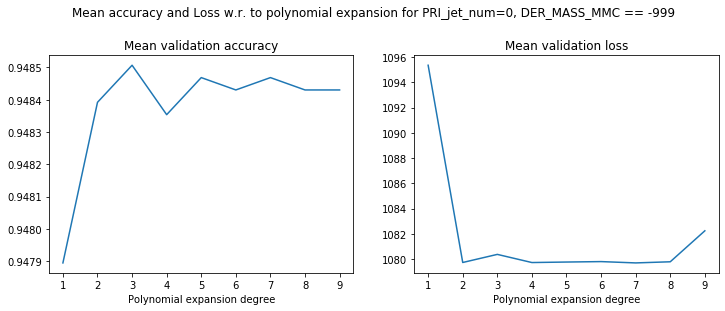

In [49]:
cross_validate_degrees(tX_0_nm, y_0_nm, 1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=0, DER_MASS_MMC == -999")

In [258]:
degree_0_nm = 3
train_ratio = 0.9
tX_0_nm_exp = expand_features(tX_0_nm, degree_0_nm, print_=True)

Performing polynomial expansion up to degree 3
Matrix has now 96 features


In [107]:
selected_cols_0_nm = select_features(tX_0_nm_exp, y_0_nm, train_ratio, 1000, 1e-5, 1)

Regularized Logistic regression got score of 0.9498660543436663, loss of 3793.217177691703
Feature selection using L1 regularization selected 58 features


In [ ]:
cross_validate_reg(tX_0_nm_exp, y_0_nm, selected_cols_0_nm, 1e-5,np.logspace(-4, 0, 5), 4, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=0, DER_MASS_MMC == -999")

In [260]:
w_0_nm = train_model(tX_0_nm_exp, y_0_nm, 0.9, selected_cols_0_nm, 1000, 1e-4, 1e-2)

Regularized Logistic regression got score of 0.9491006505931879, loss of 0.10488169644428737


### Category 1

The 22 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet' 'PRI_jet_leading_pt' 'PRI_jet_leading_eta'
 'PRI_jet_leading_phi' 'PRI_jet_all_pt']

We can see that 16 features explain 99.0% of the cumulative variance


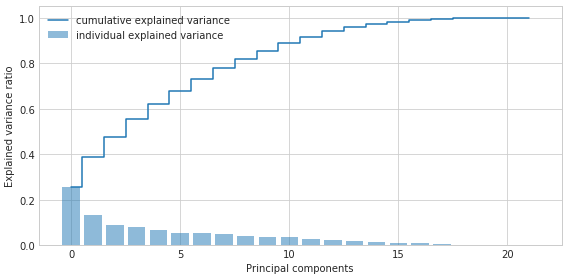

In [109]:
tX_1, matrix_1 = perform_pca(tX_1, headers, pca_threshold, True, None, print_=True)

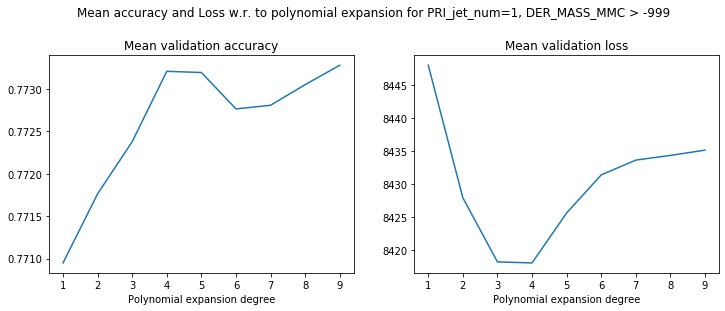

In [59]:
cross_validate_degrees(tX_1, y_1, 1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC > -999")

In [110]:
degree_1 = 4
train_ratio = 0.9
tX_1_exp = expand_features(tX_1, degree_1, print_=True)

Performing polynomial expansion up to degree 4
Matrix has now 144 features


In [111]:
selected_cols_1 = select_features(tX_1_exp, y_1, train_ratio, 1000, 1e-5, 1)

Regularized Logistic regression got score of 0.7756822403200457, loss of 30124.061097206413
Feature selection using L1 regularization selected 94 features


In [44]:
#cross_validate_reg(tX_1, y_1, headers, 1e-5, degree_1, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=1, DER_MASS_MMC > -999")

In [112]:
w_1 = train_model(tX_1_exp, y_1, 0.9, selected_cols_1, 1000, 1e-5, 1)

Gradient Descent(0/999): loss=43656.48887320703
Gradient Descent(100/999): loss=30287.067588669288
Gradient Descent(200/999): loss=30214.71669908289
Gradient Descent(300/999): loss=30184.316064536935
Gradient Descent(400/999): loss=30166.098372672655
Gradient Descent(500/999): loss=30153.602990645428
Gradient Descent(600/999): loss=30144.420362509565
Gradient Descent(700/999): loss=30137.38159970093
Gradient Descent(800/999): loss=30131.819093687292
Gradient Descent(900/999): loss=30127.31080856965
Regularized Logistic regression got score of 0.7746820974424918, loss of 30123.573643143576


### Category 1, no mass defined

The 21 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'PRI_tau_pt' 'PRI_tau_eta' 'PRI_tau_phi'
 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi' 'PRI_met' 'PRI_met_phi'
 'PRI_met_sumet' 'PRI_jet_leading_pt' 'PRI_jet_leading_eta'
 'PRI_jet_leading_phi' 'PRI_jet_all_pt']

We can see that 16 features explain 99.0% of the cumulative variance


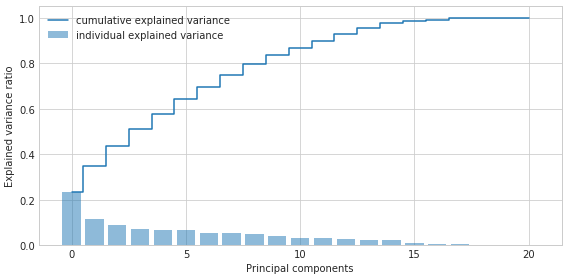

In [113]:
tX_1_nm, matrix_1_nm = perform_pca(tX_1_nm, headers, pca_threshold, True, None, print_=True)

In [ ]:
cross_validate_degrees(tX_1_nm, y_1_nm, 1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num=1, DER_MASS_MMC == -999")

In [114]:
degree_1_nm = 4
train_ratio = 0.9
tX_1_nm_exp = expand_features(tX_1_nm, degree_1_nm, print_=True)

Performing polynomial expansion up to degree 4
Matrix has now 144 features


In [115]:
selected_cols_1_nm = select_features(tX_1_nm_exp, y_1_nm, train_ratio, 1000, 1e-5, 1)

Regularized Logistic regression got score of 0.916776750330251, loss of 1609.166845427922
Feature selection using L1 regularization selected 99 features


In [48]:
#cross_validate_reg(tX_1_nm, y_1_nm, headers, 1e-5, degree_1_nm, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=1, DER_MASS_MMC == -999")

In [116]:
w_1_nm = train_model(tX_1_nm_exp, y_1_nm, 0.9, selected_cols_1_nm, 1000, 1e-4, 1)

Gradient Descent(0/999): loss=4716.866563710428
Gradient Descent(100/999): loss=1604.4002146664436
Gradient Descent(200/999): loss=1596.716042713305
Gradient Descent(300/999): loss=1594.2240875646773
Gradient Descent(400/999): loss=1592.89068533151
Gradient Descent(500/999): loss=1592.0341031079838
Gradient Descent(600/999): loss=1591.4345644785612
Gradient Descent(700/999): loss=1590.992012322168
Gradient Descent(800/999): loss=1590.6516382012703
Gradient Descent(900/999): loss=1590.3806312540482
Regularized Logistic regression got score of 0.9114927344782034, loss of 1590.1582774974702


### Category 2

The 29 features remaining after filtering zero-variance features are: 

 ['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt']

We can see that 23 features explain 99.0% of the cumulative variance


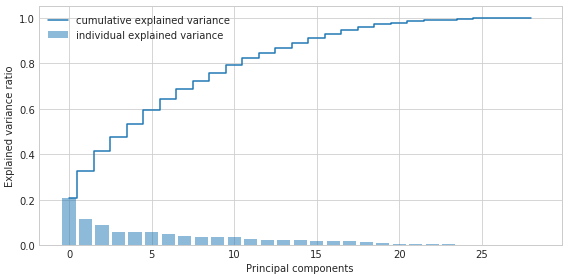

In [117]:
tX_2, matrix_2 = perform_pca(tX_2, headers, pca_threshold, True, None, print_=True)

In [50]:
cross_validate_degrees(tX_2, y_2, 1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num > 1, DER_MASS_MMC > -999")

In [118]:
degree_2 = 4
train_ratio = 0.9
tX_2_exp = expand_features(tX_2, degree_2, print_=True)

Performing polynomial expansion up to degree 4
Matrix has now 207 features


In [119]:
selected_cols_2 = select_features(tX_2_exp, y_2, train_ratio, 1000, 1e-5, 1)

Regularized Logistic regression got score of 0.7714327657075749, loss of 28888.67740702222
Feature selection using L1 regularization selected 133 features


In [52]:
#cross_validate_reg(tX_2, y_2, headers, 1e-4, degree_2, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=2, DER_MASS_MMC > -999")

In [120]:
w_2 = train_model(tX_2_exp, y_2, 0.9, selected_cols_2, 1000, 1e-5, 1)

Gradient Descent(0/999): loss=42491.30846268577
Gradient Descent(100/999): loss=29235.289465064565
Gradient Descent(200/999): loss=29040.176934257186
Gradient Descent(300/999): loss=28983.426741507385
Gradient Descent(400/999): loss=28959.412216794186
Gradient Descent(500/999): loss=28946.344274539
Gradient Descent(600/999): loss=28937.759915045204
Gradient Descent(700/999): loss=28931.416019713455
Gradient Descent(800/999): loss=28926.37002858831
Gradient Descent(900/999): loss=28922.15543895895
Regularized Logistic regression got score of 0.7705519671168526, loss of 28918.51480781907


### Category 2, no mass defined

The 28 features remaining after filtering zero-variance features are: 

 ['DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt']

We can see that 23 features explain 99.0% of the cumulative variance


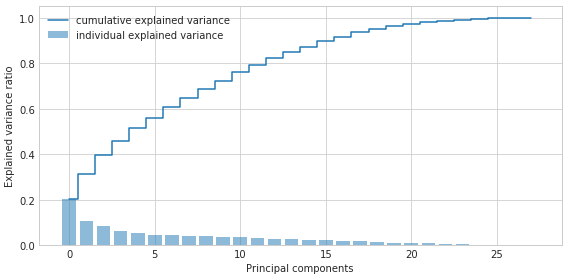

In [121]:
tX_2_nm, matrix_2_nm = perform_pca(tX_2_nm, headers, pca_threshold, True, None, print_=True)

In [ ]:
cross_validate_degrees(tX_2_nm, y_2, 1e-5, 0, np.arange(1, 10), 4, "Mean accuracy and Loss w.r. to polynomial expansion for PRI_jet_num > 1, DER_MASS_MMC == -999")

In [122]:
degree_2_nm = 4
train_ratio = 0.9
tX_2_nm_exp = expand_features(tX_2_nm, degree_2_nm, print_=True)

Performing polynomial expansion up to degree 4
Matrix has now 207 features


In [123]:
selected_cols_2_nm = select_features(tX_2_nm_exp, y_2_nm, train_ratio, 1000, 1e-5, 1)

Regularized Logistic regression got score of 0.9209932279909706, loss of 954.1564712587293
Feature selection using L1 regularization selected 141 features


In [58]:
#cross_validate_reg(tX_2_nm, y_2_nm, headers, 1e-4, degree_2_nm, "Mean accuracy and Loss w.r. to Regularization for PRI_jet_num=2, DER_MASS_MMC == -999")

In [124]:
w_2_nm = train_model(tX_2_nm_exp, y_2_nm, 0.9, selected_cols_2_nm, 1200, 1e-5, 1)

Gradient Descent(0/1199): loss=2762.884661711942
Gradient Descent(100/1199): loss=1411.0967206596176
Gradient Descent(200/1199): loss=1161.6670401635852
Gradient Descent(300/1199): loss=1067.4576895614814
Gradient Descent(400/1199): loss=1021.0497282373924
Gradient Descent(500/1199): loss=994.3824880539051
Gradient Descent(600/1199): loss=977.4453459247251
Gradient Descent(700/1199): loss=965.896791185252
Gradient Descent(800/1199): loss=957.588073130859
Gradient Descent(900/1199): loss=951.3504373623548
Gradient Descent(1000/1199): loss=946.5016755752745
Gradient Descent(1100/1199): loss=942.6211516184766
Regularized Logistic regression got score of 0.9255079006772009, loss of 939.437882278601


## Generate predictions and save ouput in csv format for submission:

In [93]:
from data_processing import prepare_for_testing

In [94]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [128]:
def predict_testset(x, h, degrees, cols, w, proj_mat):
    x, _ = perform_pca(x, h, 0, False, proj_mat)
    x = expand_features(x, degrees, print_=False)
    x = prepare_for_testing(x)
    x = x[:, cols]
    y_pred = predict_labels(w, x)
    return y_pred

In [129]:
tX_0_test, ids_0, tX_0_nm_test, ids_0_nm, tX_1_test, ids_1, tX_1_nm_test, ids_1_nm, tX_2_test, ids_2, tX_2_nm_test, ids_2_nm = split_dataset(tX_test, ids_test, jet_col=22, mass_col=0) # Split into each category

In [130]:
y_pred_0 = predict_testset(tX_0_test, headers, degree_0, selected_cols_0, w_0, matrix_0)
y_pred_0_nm = predict_testset(tX_0_nm_test, headers, degree_0_nm, selected_cols_0_nm, w_0_nm, matrix_0_nm)

In [131]:
y_pred_1 = predict_testset(tX_1_test, headers, degree_1, selected_cols_1, w_1, matrix_1)
y_pred_1_nm = predict_testset(tX_1_nm_test, headers, degree_1_nm, selected_cols_1_nm, w_1_nm, matrix_1_nm)

In [132]:
y_pred_2 = predict_testset(tX_2_test, headers, degree_2, selected_cols_2, w_2, matrix_2)
y_pred_2_nm = predict_testset(tX_2_nm_test, headers, degree_2_nm, selected_cols_2_nm, w_2_nm, matrix_2_nm)

In [133]:
ids_test = np.concatenate([ids_0, ids_0_nm, ids_1, ids_1_nm, ids_2, ids_2_nm])
y_pred = np.concatenate([y_pred_0, y_pred_0_nm, y_pred_1, y_pred_1_nm, y_pred_2, y_pred_2_nm])

In [134]:
y_pred.shape[0] == tX_test.shape[0]

True

In [135]:
OUTPUT_PATH = 'test.csv' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights_ridge, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [136]:
import pandas as pd

In [141]:
labels = pd.read_csv('../data/solution-with-features.csv')[['Id', 'Prediction']]
pred = pd.read_csv('test.csv')

In [151]:
c = pred.merge(labels, on='Id')

In [154]:
len(c[c['Prediction_x'] == c['Prediction_y']]) / len(pred)

0.8076334212073111